Using passengers dataset to understand the concepts of time series.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
dataset = pd.read_csv('AirPassengers.csv')

In [3]:
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
dataset["Month"].dtype

dtype('O')

In [5]:
dataset["Month"] = pd.to_datetime(dataset["Month"], infer_datetime_format=True)
indexdataset = dataset.set_index(["Month"])

In [6]:
dataset.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [7]:
dataset["Month"].dtype

dtype('<M8[ns]')

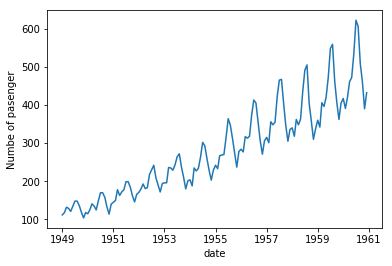

In [8]:
# plot the date and the passengers

plt.xlabel("date")
plt.ylabel("Numbe of pasenger")
plt.plot(indexdataset)

Stationarity - How constant is the mean, variance, what is the probability the the time behaviour will be the same in the future.

###### check if the data is stationary
1. ADCF test, rolling statistics

if the mean and standard deviation is constant, the data is stationary

In [9]:
# using ADFC test
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries_df):

    # determining rolling statictics
    rolmean = timeseries_df.rolling(window=12).mean() # window 12, monthly
    rolstd = timeseries_df.rolling(window=12).std()
    
    # ploting rolling
    origi = plt.plot(timeseries_df, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling mean")
    std = plt.plot(rolstd, color="black", label="Rolling std")
    plt.legend(loc='best')
    plt.title("rolling statistics")
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print("results of ADFC test")
    dftest = adfuller(timeseries_df["#Passengers"], autolag="AIC")

    dfoutput = pd.Series(dftest[0:4], index=["Test statistics", "p-value", "#lags Used", "Number of observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical value (%s)" %key] = value
    print(dfoutput)

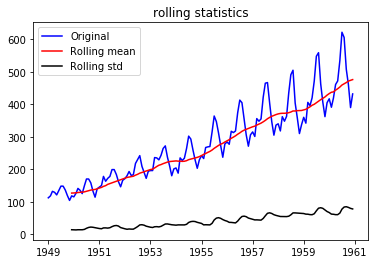

results of ADFC test
Test statistics                  0.815369
p-value                          0.991880
#lags Used                      13.000000
Number of observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [10]:
test_stationary(indexdataset)

If the ‘Test Statistics’ is less than the ‘Critical Value’, the data is stationary.

##### Make time series stationary

Trend and seasionality make time not to be stationary

##### Estimating & Eliminating Trend

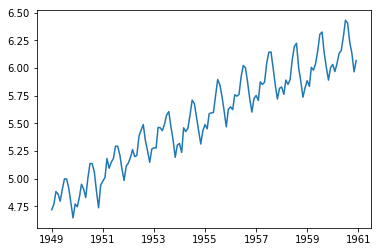

In [11]:
# use transformation
index_dataset_log = np.log(indexdataset)
plt.plot(index_dataset_log)

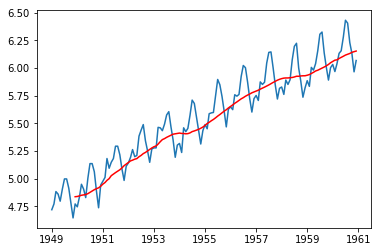

In [12]:
# moving average
moving_average = index_dataset_log.rolling(window=12).mean()
moving_std = index_dataset_log.rolling(window=12).std()
plt.plot(index_dataset_log)
plt.plot(moving_average, color="red")
# plt.plot(moving_std, color="black", label="Rolling std")

In [13]:
# get the difference 
difference_df = index_dataset_log - moving_average

# drop the None values
difference_df.dropna(inplace=True)
difference_df.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


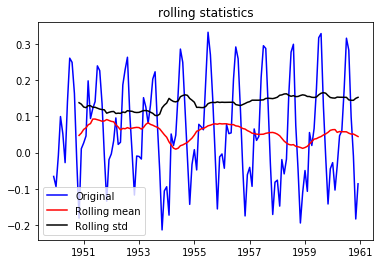

results of ADFC test
Test statistics                 -3.162908
p-value                          0.022235
#lags Used                      13.000000
Number of observations Used    119.000000
Critical value (1%)             -3.486535
Critical value (5%)             -2.886151
Critical value (10%)            -2.579896
dtype: float64


In [14]:
test_stationary(difference_df)

Test statistics is less than critical value(5%)

use exponentially weighted moving average where weights are assigned to all the previous values with a decay factor

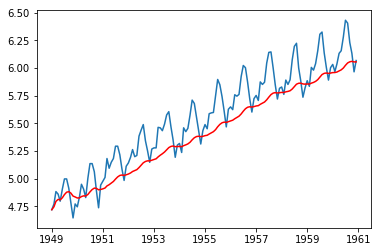

In [15]:
weighted_mean = index_dataset_log.ewm(halflife=12).mean()
plt.plot(index_dataset_log)
plt.plot(weighted_mean, color='red')

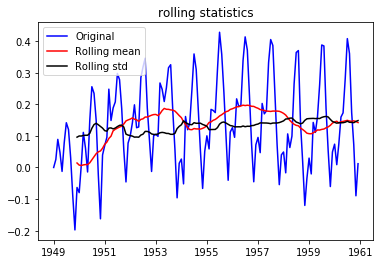

results of ADFC test
Test statistics                 -3.601262
p-value                          0.005737
#lags Used                      13.000000
Number of observations Used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [16]:
weighted_difference = index_dataset_log - weighted_mean
test_stationary(weighted_difference)

the test statistic is smaller than the 1% critical value, which is better than the previous case

###### Differencing – 
taking the differece with a particular time lag

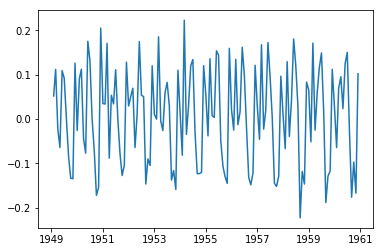

In [17]:
difference_shift = index_dataset_log - index_dataset_log.shift()
plt.plot(difference_shift)

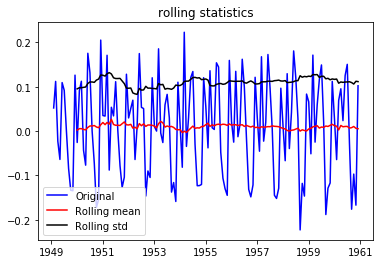

results of ADFC test
Test statistics                 -2.717131
p-value                          0.071121
#lags Used                      14.000000
Number of observations Used    128.000000
Critical value (1%)             -3.482501
Critical value (5%)             -2.884398
Critical value (10%)            -2.578960
dtype: float64


In [18]:
difference_shift.dropna(inplace=True)
test_stationary(difference_shift)

##### Decomposing


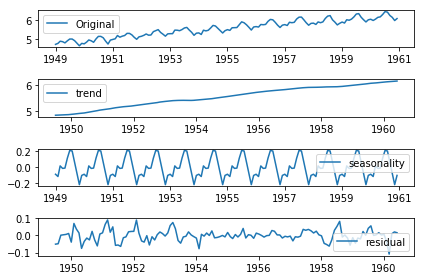

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(index_dataset_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(index_dataset_log, label="Original")
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label="trend")
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label="seasonality")
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label="residual")
plt.legend(loc='best')
plt.tight_layout()

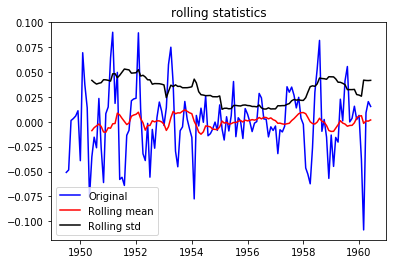

results of ADFC test
Test statistics               -6.332387e+00
p-value                        2.885059e-08
#lags Used                     9.000000e+00
Number of observations Used    1.220000e+02
Critical value (1%)           -3.485122e+00
Critical value (5%)           -2.885538e+00
Critical value (10%)          -2.579569e+00
dtype: float64


In [20]:
decomposed_log_data = residual
decomposed_log_data.dropna(inplace=True)
test_stationary(decomposed_log_data)

##### Forecasting time series

ARIMA model
parameter (p, q, d)
Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

- TO determine the value of p and q, we use two plots: 1. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

In [21]:
# ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(difference_shift, nlags=20)
lag_pacf = pacf(difference_shift, nlags=20, method='ols')

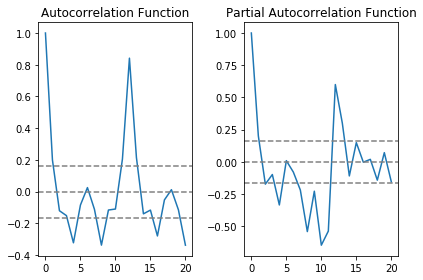

In [22]:
# plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(difference_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(difference_shift)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(difference_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(difference_shift)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

##### ARIMA model

Text(0.5,1,'RSS: 1.5023')

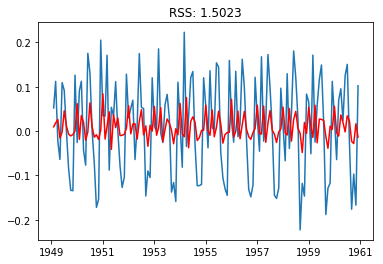

In [23]:
from statsmodels.tsa.arima_model import ARIMA
# AR MODEL
model = ARIMA(index_dataset_log, order=(2, 1, 0))  # (p=2, d=1, q=2)
results_AR = model.fit(disp=-1)
plt.plot(difference_shift)
plt.plot(results_AR.fittedvalues, color='red')
# Residual Sum of Squares
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-difference_shift["#Passengers"])**2))

Text(0.5,1,'RSS: 1.4721')

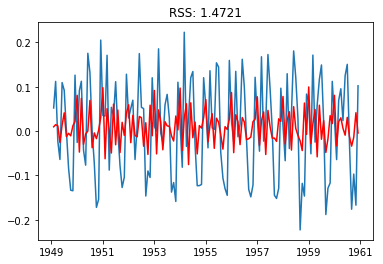

In [24]:
# MA Model
model = ARIMA(index_dataset_log, order=(0, 1, 2))  # (p=2, d=1, q=2)
results_MA = model.fit(disp=-1)
plt.plot(difference_shift)
plt.plot(results_MA.fittedvalues, color='red')
# Residual Sum of Squares
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-difference_shift["#Passengers"])**2))

/Users/rose/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS: 1.0292')

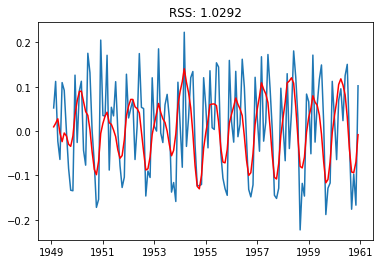

In [27]:
# combine the two models
model = ARIMA(index_dataset_log, order=(2, 1, 2))  # (p=2, d=1, q=2)
results_ARIMA = model.fit(disp=-1)
plt.plot(difference_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
# Residual Sum of Squares
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-difference_shift["#Passengers"])**2))

In [28]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [30]:
# cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [33]:
predictions_ARIMA_log = pd.Series(index_dataset_log["#Passengers"].iloc[0], index=index_dataset_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

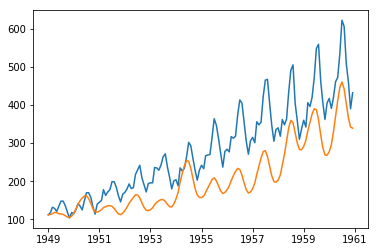

In [37]:
#compare the values
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexdataset)
plt.plot(predictions_ARIMA)

In [38]:
# Predict
index_dataset_log

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
1949-06-01,4.905275
1949-07-01,4.997212
1949-08-01,4.997212
1949-09-01,4.912655


predict for 10 years- we have 12 months, therefore the steps = 12 * 10 = 120, total points will be 144 rows + 120 = 264

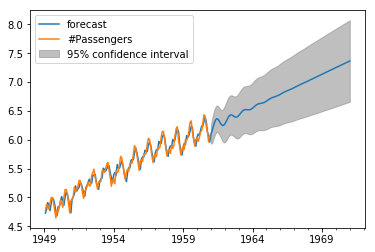

In [40]:
results_ARIMA.plot_predict(1, 264)
x = results_ARIMA.forecast(steps=120)

In [43]:
len(x[1])

120